In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import numpy as np
import crocoddyl
import torch 
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sqnet import SQNet
from fnet import FNet
import matplotlib.pyplot as plt
%matplotlib inline   

In [3]:
def data(size=1000):
    x = []
    y = []
    
    for _ in range(size):
        xyz = np.array([np.random.uniform(-2.1, 2.1), 
                   np.random.uniform(-2.1, 2.1),
                   0.])
        
        model = crocoddyl.ActionModelUnicycle()
        T = 30
        model.costWeights = np.matrix([1,1]).T

        problem = crocoddyl.ShootingProblem(xyz.T, [ model ] * T, model)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve([], [], 1000)
        x.append(xyz)
        y.append([ddp.cost])
        
    return torch.tensor(x, dtype = torch.float32), torch.tensor(y, dtype = torch.float32)

In [4]:
sqnet  = torch.load("sqnet.pth")
fnet = torch.load("value.pth")

In [5]:

x = 0.99
y = np.linspace(-1., 1., 100)
xtest = np.array([ [x,x2, 0.] for x2 in y ])

<Figure size 432x288 with 0 Axes>

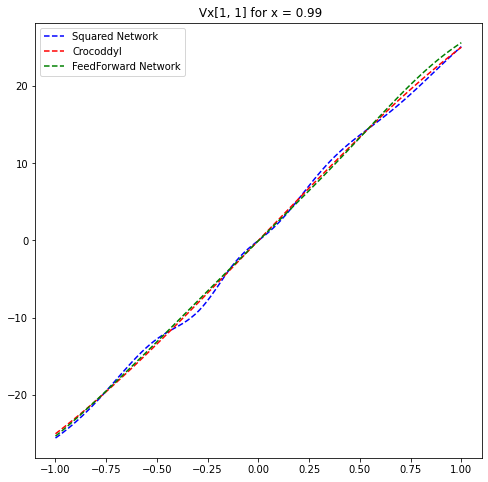

In [6]:
# Plot grad1
sqh = []
vh = []
ch = []
for test in xtest:
    test = torch.tensor(test, dtype = torch.float32)
    h = sqnet.jacobian(test).detach().numpy()
    sqh.append(h[1])
    
    h_ = torch.autograd.functional.jacobian(fnet, test).detach().numpy().squeeze()
    vh.append(h_[1])
    
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T

    problem = crocoddyl.ShootingProblem(np.array(test).T, [ model ] * T, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [], 1000)
    vxx = ddp.Vx[0]
    ch.append(vxx[1])
    
    

plt.clf()
plt.figure(figsize=(8, 8))
plt.plot(xtest[:,1], sqh, '--b', label = "Squared Network")
plt.plot(xtest[:,1], ch, '--r', label = "Crocoddyl")
plt.plot(xtest[:,1], vh, '--g', label = "FeedForward Network")
plt.title(f" Vx[1, 1] for x = {x}")
plt.legend()
#plt.yticks(np.arange(0, 50, 10))
#plt.savefig("Grad2.png")

<Figure size 432x288 with 0 Axes>

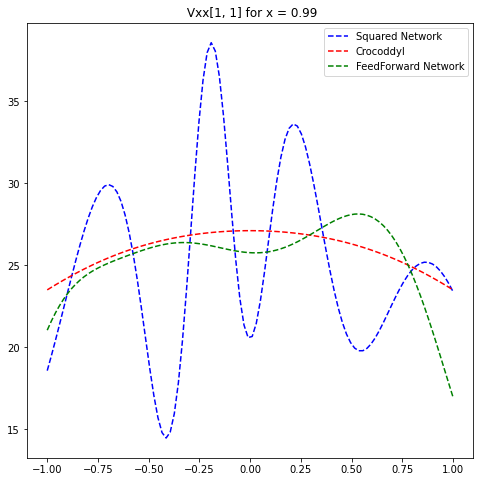

In [7]:
# Plot grad2
sqh = []
vh = []
ch = []
for test in xtest:
    test = torch.tensor(test, dtype = torch.float32)
    h = sqnet.hessian(test).detach().numpy().squeeze()
    sqh.append(np.diagonal(h)[1])
    
    h_ = torch.autograd.functional.hessian(fnet, test).detach().numpy().squeeze()
    vh.append(np.diagonal(h_)[1])
    
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T

    problem = crocoddyl.ShootingProblem(np.array(test).T, [ model ] * T, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [], 1000)
    vxx = ddp.Vxx[0]
    ch.append(np.diagonal(vxx)[1])
    
    

plt.clf()
plt.figure(figsize=(8, 8))
plt.plot(xtest[:,1], sqh, '--b', label = "Squared Network")
plt.plot(xtest[:,1], ch, '--r', label = "Crocoddyl")
plt.plot(xtest[:,1], vh, '--g', label = "FeedForward Network")
plt.title(f" Vxx[1, 1] for x = {x}")
plt.legend()

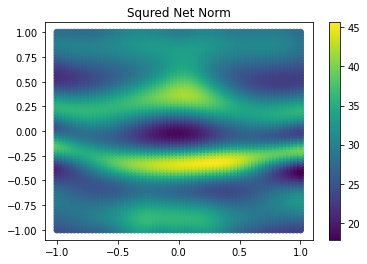

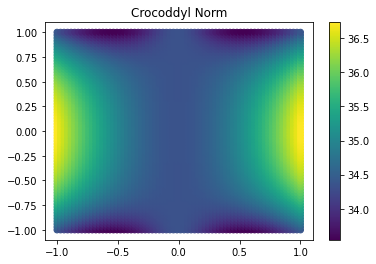

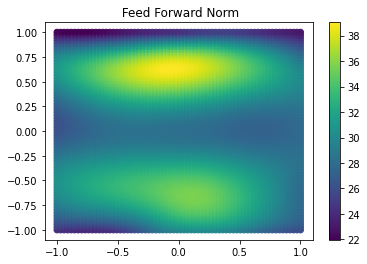

In [17]:
# Plot Vxxnorm
def griddata(size):
    """
    Will return size^2 points
    """
    xrange = np.linspace(-1.,1.,size)
    xtest = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    return xtest

grid = griddata(70)

sqh = []
vh = []
ch = []
for test in grid:
    test = torch.tensor(test, dtype = torch.float32)
    h = sqnet.hessian(test).detach().numpy().squeeze()
    sqh.append(np.linalg.norm(h))
    
    h_ = torch.autograd.functional.hessian(fnet, test).detach().numpy().squeeze()
    vh.append(np.linalg.norm(h_))
    
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T
    problem = crocoddyl.ShootingProblem(np.array(test).T, [ model ] * T, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [], 1000)
    vxx = ddp.Vxx[0]
    ch.append(np.linalg.norm(vxx))
    
ch = np.array(ch).reshape(-1, 1)
sqh = np.array(sqh).reshape(-1, 1)
vh = np.array(vh).reshape(-1, 1)
    
plt.clf()
plt.scatter(grid[:,0],grid[:,1], c = sqh)
plt.colorbar()
plt.title("Squred Net Norm")
plt.show()
plt.clf()
plt.scatter(grid[:,0],grid[:,1], c = ch)
plt.colorbar()
plt.title("Crocoddyl Norm")
plt.show()
plt.clf()
plt.scatter(grid[:,0],grid[:,1], c = vh)
plt.title(f" Feed Forward Norm")
plt.colorbar()
plt.show()

array([[24.395834],
       [24.995642],
       [25.587914],
       ...,
       [28.56902 ],
       [28.304808],
       [27.937616]], dtype=float32)